In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [77]:
path = '/home/lucaspancotto/code/JoacoSoulez/mental_health_first_aid_evaluation/data/twitter_reddit_text.csv'
core_path = '/home/lucaspancotto/code/JoacoSoulez/mental_health_first_aid_evaluation/data/sorted_coefs_naivebayes_twitterreddit.csv'
data= pd.read_csv(f'{path}')
core_data = pd.read_csv(f'{core_path}')




In [75]:
core_data.head(30)

,Unnamed: 0,0
0,feel,-4.990164
1,depress,-5.006754
2,like,-5.237492
3,want,-5.350858
4,get,-5.560917
5,life,-5.566263
6,know,-5.591696
7,go,-5.640298
8,not,-5.735271
9,can,-5.735307


In [80]:
core_words = core_data['Unnamed: 0'].to_list()[:5000]

In [81]:
len(core_words)

5000

In [47]:
data.head()

,Unnamed: 0,clean_text,label
0,0,lay bed hour point back pain get work minut cl...,1
1,1,dlitedaili dont play wouldnt want anyth world,0
2,2,rewebcoach hey handsom time get day go,0
3,3,get readi tenni maryyi,0
4,4,hear song band almost never play favourit radi...,0


In [82]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

In [83]:
def stop_core_words(txt):
    txt = word_tokenize(str(txt))
    txt = ' '.join(word for word in txt if not word in core_words)
    return txt

In [84]:
stop_core_words('depress my goodness oh fuck')

'my goodness'

In [85]:
data_stopped = data.clean_text.apply(stop_core_words)

In [86]:
data_stopped

0                                       
1                     dlitedaili wouldnt
2                     rewebcoach handsom
3                           tenni maryyi
4                         favourit radio
                      ...               
25363                                   
25364                    u prayer asap u
25365                                   
25366    l demolish highlight inadequaci
25367            burghrealtor pghjen pie
Name: clean_text, Length: 25368, dtype: object

In [87]:
X = data_stopped
y = data.label

X_train, X_test, y_train, y_test = train_test_split(X , y ,test_size = 0.3 )
print('length of X_train',len(X_train), 'length of X_test',len(X_test), 'length of y_train',len(y_train), 'length of y_test',len(y_test))

X_train = [word_tokenize(str(_)) for _ in X_train]
X_test = [word_tokenize(str(_)) for _ in X_test]


length of X_train 17757 length of X_test 7611 length of y_train 17757 length of y_test 7611


# embed data

In [88]:
# This line trains an entire embedding for the words in your train set
word2vec = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=5)

def embed_sentence(word2vec, sentence):
    # $CHALLENGIFY_BEGIN
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)
def embedding(word2vec, sentences):
    # $CHALLENGIFY_BEGIN
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed
    # $CHALLENGIFY_END
    
X_train = embedding(word2vec, X_train)
X_test = embedding(word2vec, X_test)


In [89]:
#cortamos en 400 words
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_pad = pad_sequences(X_train, dtype='float', padding='post', maxlen= 400,truncating= 'post')
X_test_pad = pad_sequences(X_test, dtype='float', padding='post', maxlen = 400 , truncating = 'post')


# model rnn

In [90]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy', 'AUC','Precision','Recall'])
    
    return model

model = init_model()

In [91]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3, restore_best_weights=True)

history_fit = model.fit(X_train_pad, y_train, 
          batch_size = 32,
          epochs=100,
          validation_split=0.3,
          callbacks=[es],
          verbose = 1
         )

2022-03-09 16:59:43.740277: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1988640000 exceeds 10% of free system memory.


Epoch 1/100
389/389 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.5859 - auc: 0.6129 - precision: 0.6194 - recall: 0.4605

2022-03-09 17:03:35.675400: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 852480000 exceeds 10% of free system memory.


389/389 [==============================] - 263s 650ms/step - loss: 0.6511 - accuracy: 0.5859 - auc: 0.6129 - precision: 0.6194 - recall: 0.4605 - val_loss: 0.6405 - val_accuracy: 0.6096 - val_auc: 0.6268 - val_precision: 0.7111 - val_recall: 0.3623
Epoch 2/100
389/389 [==============================] - 97s 250ms/step - loss: 0.6408 - accuracy: 0.6053 - auc: 0.6240 - precision: 0.7302 - recall: 0.3426 - val_loss: 0.6424 - val_accuracy: 0.6107 - val_auc: 0.6209 - val_precision: 0.7084 - val_recall: 0.3694
Epoch 3/100
389/389 [==============================] - 98s 252ms/step - loss: 0.6396 - accuracy: 0.6037 - auc: 0.6245 - precision: 0.7233 - recall: 0.3450 - val_loss: 0.6383 - val_accuracy: 0.6100 - val_auc: 0.6224 - val_precision: 0.7112 - val_recall: 0.3634
Epoch 4/100
389/389 [==============================] - 98s 252ms/step - loss: 0.6385 - accuracy: 0.6055 - auc: 0.6282 - precision: 0.7212 - recall: 0.3530 - val_loss: 0.6393 - val_accuracy: 0.6102 - val_auc: 0.6246 - val_precision:

In [92]:
def plot_loss(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    #ax1.set_ylim(ymin=0, ymax=200)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    
    
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('Epoch')
    #ax2.set_ylim(ymin=0, ymax=20)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    plt.show()



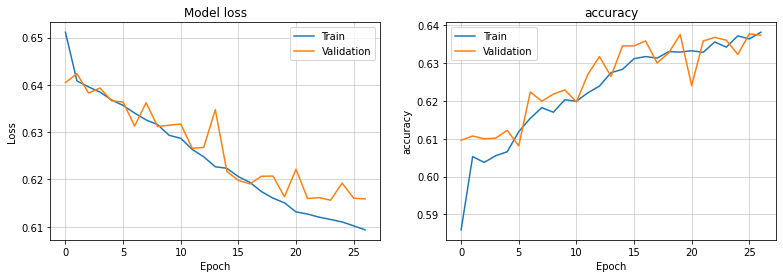

In [93]:
plot_loss(history_fit)

In [68]:
res = model.evaluate(X_test_pad, y_test, verbose = 1, return_dict=True)
res

2022-03-09 16:10:51.909312: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1217760000 exceeds 10% of free system memory.


238/238 [==============================] - 15s 64ms/step - loss: 0.1827 - accuracy: 0.9267 - auc: 0.9759 - precision: 0.9659 - recall: 0.8848


[0.1827172487974167,
 0.9266850352287292,
 0.975908100605011,
 0.96590256690979,
 0.8847768902778625]

In [71]:
import joblib

In [72]:
joblib.dump(model , 'rnn_tweetreddit_coreless100.sav')

2022-03-09 16:51:48.360174: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://ba185c47-9641-48a7-b1ec-7beb6b3042e3/assets


INFO:tensorflow:Assets written to: ram://ba185c47-9641-48a7-b1ec-7beb6b3042e3/assets


['rnn_tweetreddit_coreless100.sav']